### 1. Revisit the all-weather portfolio you crafted. 
Put the portfolio daily and cumulative returns of the three portfolios (i.e., equally-weighted, maximum Sharpe, or minimum volatility) side-by-side in a dataframe. If you have attempted the optional bonus, why not include the portfolios with L2 regularization and Black-Litterman model too.

In [1]:
import refinitiv.data.eikon as ek
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ek.set_app_key('76fd368660db4b90b1f41434404c637573a836aa')
#DEFAULT_CODE_BOOK_APP_KEY

/opt/conda/lib/python3.8/site-packages/refinitiv/data/eikon/__init__.py:15:FutureWarning: The refinitiv.data.eikon module will be removed in future library version v2.0. Please install and use the 'eikon' Python library instead or migrate your code to the Refinitiv/LSEG Data Library


In [2]:
# Let's start with my personal all-weather portfolio
symbols_list = ['AAPL.O','KMI','CCJ', 'BP']

# Define date ranges (splitting by year, in order to get around data retrieval limits)
date_ranges = [('2017-08-31', '2018-08-31'), ('2018-09-01', '2019-08-31'), 
               ('2019-09-01', '2020-08-31'), ('2020-09-01', '2021-08-31'), 
               ('2021-08-31', '2022-08-31')]

# Initialize empty DataFrame
price = pd.DataFrame()

# Loop through date ranges and fetch data
for start_date, end_date in date_ranges:
    temp_data = ek.get_timeseries(symbols_list, fields='CLOSE', start_date=start_date, end_date=end_date, corax='adjusted')
    price = pd.concat([price, temp_data])
    
price

CLOSE,AAPL.O,KMI,CCJ,BP
Date,,,,
2017-08-31,41.0,19.33,10.03,34.73
2017-09-01,41.0125,19.36,10.01,34.77
2017-09-05,40.52,19.35,9.96,34.95
2017-09-06,40.4775,19.33,10.07,35.32
2017-09-07,40.315,19.14,10.13,35.5
...,...,...,...,...
2022-08-25,170.03,19.26,27.25,32.67
2022-08-26,163.62,18.99,26.66,32.33
2022-08-29,161.38,18.94,29.14,32.47


In [3]:
daily_returns = price.pct_change()[1:]
daily_returns.head()

CLOSE,AAPL.O,KMI,CCJ,BP
Date,,,,
2017-09-01,0.000305,0.001552,-0.001994,0.001152
2017-09-05,-0.012009,-0.000517,-0.004995,0.005177
2017-09-06,-0.001049,-0.001034,0.011044,0.010587
2017-09-07,-0.004015,-0.009829,0.005958,0.005096
2017-09-08,-0.016309,0.0,-0.017769,-0.00507


In [4]:
# Create equal weights for the portfolio
ew_weights = np.array([0.25, 0.25, 0.25, 0.25])

In [5]:
# Import the packages 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(price)

# Calculate the covariance matrix S
sigma = risk_models.sample_cov(price)

# Obtain the efficient frontier
ef = EfficientFrontier(mu, sigma)

# Calculate weights for the maximum Sharpe ratio portfolio
raw_weights_maxsharpe = ef.max_sharpe()
cleaned_weights_maxsharpe = ef.clean_weights()
optimal_weights_maxsharpe = np.array(list(cleaned_weights_maxsharpe.values())) # Get interpretable weights

In [6]:
# Obtain the efficient frontier again
ef2 = EfficientFrontier(mu, sigma)

# Calculate weights for the minimum volatility ratio portfolio
raw_weights_minvol = ef2.min_volatility()
cleaned_weights_minvol = ef2.clean_weights()
optimal_weights_minvol = np.array(list(ef2.clean_weights().values())) 

In [7]:
# Calculate daily and cumulative returns for equal weighted portfolio 
ew_daily_ret = daily_returns.dot(ew_weights)
ew_cum_ret = (1 + ew_daily_ret).cumprod()

# And also for maxsharpe and minvol portfolios
maxsharpe_daily_ret = daily_returns.dot(optimal_weights_maxsharpe)
maxsharpe_cum_ret = (1 + maxsharpe_daily_ret).cumprod()
minvol_daily_ret = daily_returns.dot(optimal_weights_minvol)
minvol_cum_ret = (1 + minvol_daily_ret).cumprod()

In [8]:
portfolios_daily_rets = pd.concat([ew_daily_ret, maxsharpe_daily_ret, minvol_daily_ret], axis=1)
portfolios_daily_rets.set_axis(['Equal_Wtd','Max_Sharpe','Min_Vol'], axis=1, inplace=True)
portfolios_cum_rets = pd.concat([ew_cum_ret, maxsharpe_cum_ret, minvol_cum_ret], axis = 1)
portfolios_cum_rets.set_axis(['Equal_Wtd','Max_Sharpe','Min_Vol'], axis=1, inplace=True)

print(portfolios_daily_rets)
print(portfolios_cum_rets)

           Equal_Wtd Max_Sharpe   Min_Vol
Date                                     
2017-09-01  0.000254  -0.000025  0.000657
2017-09-05 -0.003086  -0.011003 -0.005253
2017-09-06  0.004887   0.000685  0.001534
2017-09-07 -0.000697  -0.002585 -0.003874
2017-09-08 -0.009787  -0.016518 -0.009461
...              ...        ...       ...
2022-08-25  0.009675   0.014057  0.010121
2022-08-26 -0.020944  -0.035399 -0.024801
2022-08-29  0.020258   0.001608  0.000761
2022-08-30  -0.01335  -0.010455 -0.018049
2022-08-31 -0.013902   -0.01167 -0.011646

[1259 rows x 3 columns]
           Equal_Wtd Max_Sharpe   Min_Vol
Date                                     
2017-09-01  1.000254   0.999975  1.000657
2017-09-05  0.997167   0.988973  0.995401
2017-09-06   1.00204    0.98965  0.996928
2017-09-07  1.001342   0.987092  0.993066
2017-09-08  0.991541   0.970786  0.983671
...              ...        ...       ...
2022-08-25  2.117117   4.194915   2.30232
2022-08-26  2.072776   4.046421  2.245222
2022-08-2

### 2. Examine visually the drawdown behavior of each portfolio.

In [9]:
# For equal wtd portfolio
# Calculate the running maximum
ew_running_max = np.maximum.accumulate(ew_cum_ret)

# Ensure the value never drops below 1
ew_running_max[ew_running_max<1] = 1

# Calculate the percentage drawdown
ew_drawdown = (ew_cum_ret)/ew_running_max - 1

In [10]:
# For max sharpe portfolio
# Calculate the running maximum
maxsharpe_running_max = np.maximum.accumulate(maxsharpe_cum_ret)

# Ensure the value never drops below 1
maxsharpe_running_max[maxsharpe_running_max<1] = 1

# Calculate the percentage drawdown
maxsharpe_drawdown = (maxsharpe_cum_ret)/maxsharpe_running_max - 1

In [11]:
# For min volatility portfolio
# Calculate the running maximum
minvol_running_max = np.maximum.accumulate(minvol_cum_ret)

# Ensure the value never drops below 1
minvol_running_max[minvol_running_max<1] = 1

# Calculate the percentage drawdown
minvol_drawdown = (minvol_cum_ret)/minvol_running_max - 1

Text(0, 0.5, 'Drawdown index')

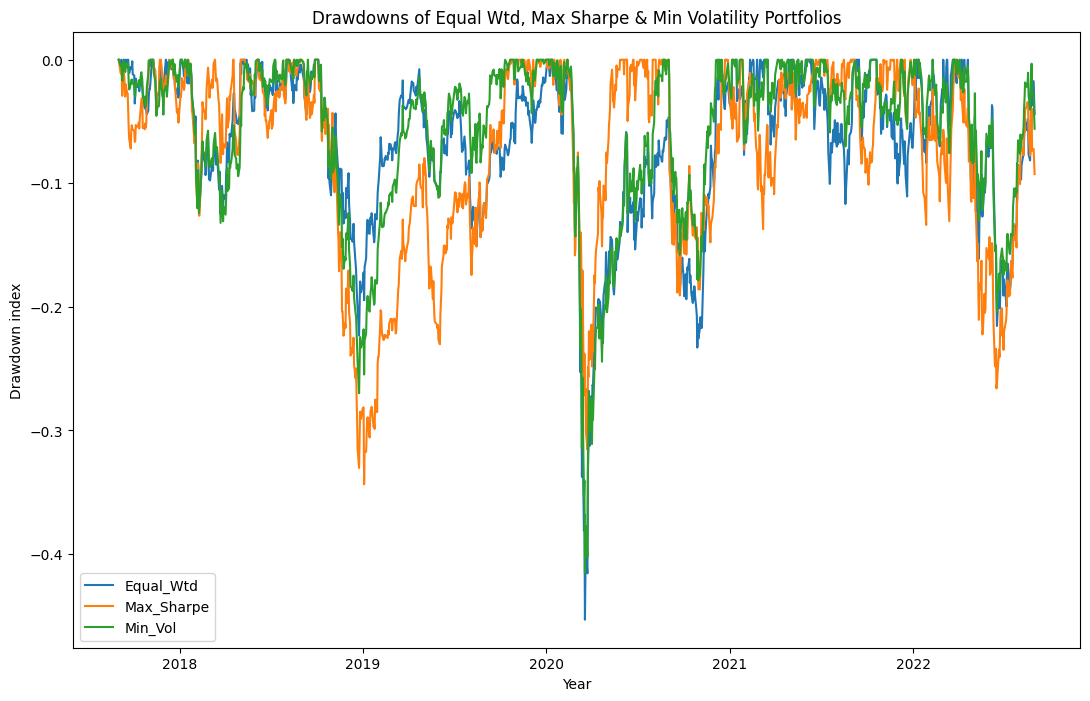

In [12]:
portfolios_drawdown = pd.concat([ew_drawdown, maxsharpe_drawdown, minvol_drawdown], axis=1)
portfolios_drawdown.set_axis(['Equal_Wtd','Max_Sharpe','Min_Vol'], axis=1, inplace=True)

# Plot
plt.figure(figsize=(13, 8))
for column in portfolios_drawdown.columns:
    plt.plot(portfolios_drawdown.index, portfolios_drawdown[column], label=column)
plt.title('Drawdowns of Equal Wtd, Max Sharpe & Min Volatility Portfolios')
plt.legend()
plt.xlabel("Year")
plt.ylabel('Drawdown index')

Within the timeframe of 5 years, the max drawdowns of each portfolio are: 
Equal_Wtd    -0.453102
Max_Sharpe   -0.343507
Min_Vol      -0.415197
dtype: object


Text(0, 0.5, 'Drawdown index')

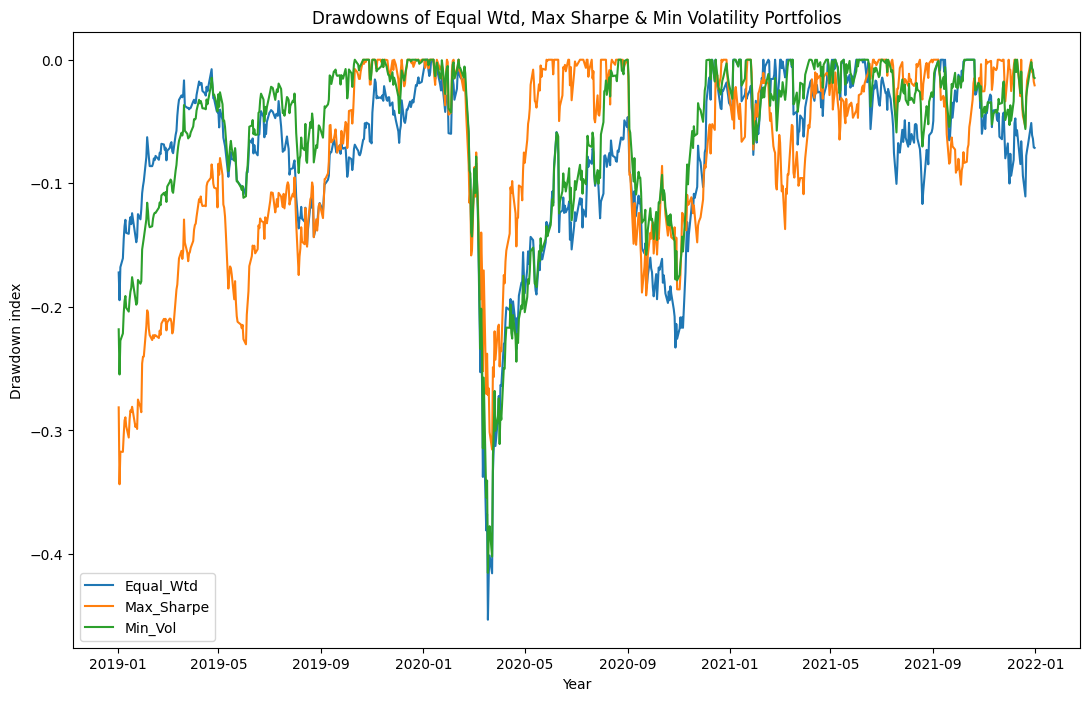

In [13]:
print(f"Within the timeframe of 5 years, the max drawdowns of each portfolio are: \n{portfolios_drawdown.min()}")

# Zooming into range of 2019Y to 2021Y
drawdown_filterbytime = portfolios_drawdown.loc['2019-01-01':'2021-12-31']

plt.figure(figsize=(13, 8))
for new_column in drawdown_filterbytime.columns:
    plt.plot(drawdown_filterbytime.index, drawdown_filterbytime[new_column], label=new_column)
plt.title('Drawdowns of Equal Wtd, Max Sharpe & Min Volatility Portfolios')
plt.legend()
plt.xlabel("Year")
plt.ylabel('Drawdown index')

We can see equal wtd portfolio has the greatest drawdown among the 3 portfolios of my choice within these 5 years, both visually and using the .min() function. It happened about April 2020, probably because of the tougher global challenges against COVID-19 pandemic as we can also see the other 2 portfolios tumbled in values but not as great as equal wtd portfolio's.  

### 3. Calculate the Value-at-Risk of each portfolio at 99% using the empirical (historical) distribution and theoretical distribution. 
Create graphs that show the empirical distribution with two vertical lines, representing the Value-at-Risk at 99% derived from the empirical and theoretical distribution, respectively.

1% historical VaR of equal wtd portfolio is: -4.0218%.
1% parametric/ theoretical VaR for equal wtd portfolio is: -3.9989%


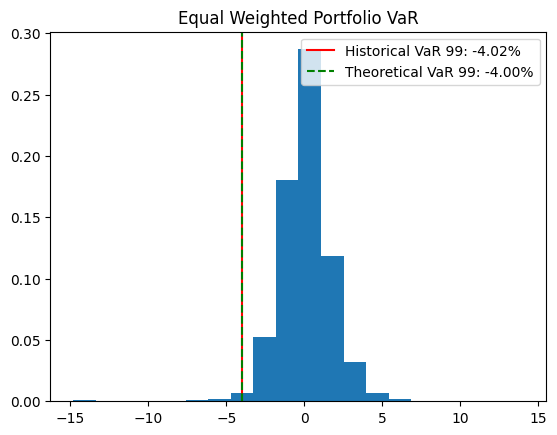

In [14]:
from scipy.stats import norm
alpha = .01

# For equal wtd portfolio
ew_daily_return = daily_returns.dot(ew_weights)
ew_StockReturns_perc = ew_daily_return*100

# Calculate Historical VaR(99)
ew_Hvar_99 = np.percentile(ew_StockReturns_perc, 1)
print(f"1% historical VaR of equal wtd portfolio is: {np.round(ew_Hvar_99,4)}%.")

# Sort the returns for plotting
ew_sorted_rets = sorted(ew_StockReturns_perc)

# Calculate Theoretical and parametric VaR(99)
ew_mean = np.mean(ew_StockReturns_perc)
ew_std = np.std(ew_StockReturns_perc)
ew_Tvar_99 = norm.ppf(alpha, ew_mean, ew_std)
print(f"1% parametric/ theoretical VaR for equal wtd portfolio is: {round(ew_Tvar_99,4)}%")

# Plot the probability of each sorted return quantile
plt.hist(ew_sorted_rets, bins=20 , density=True, stacked=True)

# Denote both historical (i.e. empirical) and parametric VaR 99 quantile
plt.axvline(x=ew_Hvar_99, color='r', linestyle='-', label="Historical VaR 99: {0:.2f}%".format(ew_Hvar_99))
plt.axvline(x=ew_Tvar_99, color='g', linestyle='--', label="Theoretical VaR 99: {0:.2f}%".format(ew_Tvar_99))
plt.title("Equal Weighted Portfolio VaR")
plt.legend()
plt.show()

1% historical VaR of max Sharpe portfolio is: -4.9076%.
1% parametric/ theoretical VaR for max Sharpe portfolio is: -4.318%


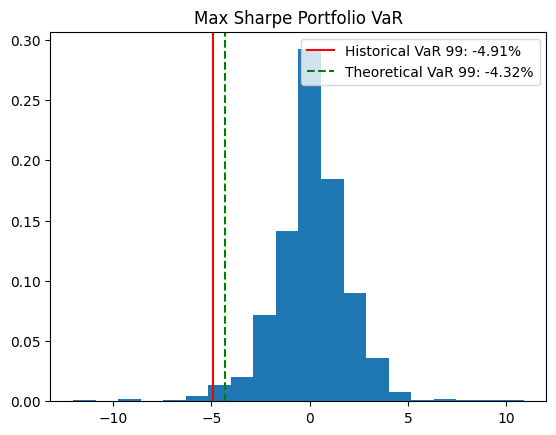

In [18]:
# For max sharpe portfolio, make sure you run first question codes first 
ms_daily_return = daily_returns.dot(optimal_weights_maxsharpe)
ms_StockReturns_perc = ms_daily_return*100

# Calculate Historical VaR(99)
ms_Hvar_99 = np.percentile(ms_StockReturns_perc, 1)
print(f"1% historical VaR of max Sharpe portfolio is: {np.round(ms_Hvar_99,4)}%.")

# Sort the returns for plotting
ms_sorted_rets = sorted(ms_StockReturns_perc)

# Calculate Theoretical and parametric VaR(99)
ms_mean = np.mean(ms_StockReturns_perc)
ms_std = np.std(ms_StockReturns_perc)
ms_Tvar_99 = norm.ppf(alpha, ms_mean, ms_std)
print(f"1% parametric/ theoretical VaR for max Sharpe portfolio is: {round(ms_Tvar_99,4)}%")

# Plot the probability of each sorted return quantile
plt.hist(ms_sorted_rets, bins=20 , density=True, stacked=True)

# Denote the VaR 99 quantile
plt.axvline(x=ms_Hvar_99, color='r', linestyle='-', label="Historical VaR 99: {0:.2f}%".format(ms_Hvar_99))
plt.axvline(x=ms_Tvar_99, color='g', linestyle='--', label="Theoretical VaR 99: {0:.2f}%".format(ms_Tvar_99))
plt.title("Max Sharpe Portfolio VaR")
plt.legend()
plt.show()

1% historical VaR of min volatility portfolio is: -4.2755%.
1% parametric/ theoretical VaR for min volatility portfolio is: -3.75%


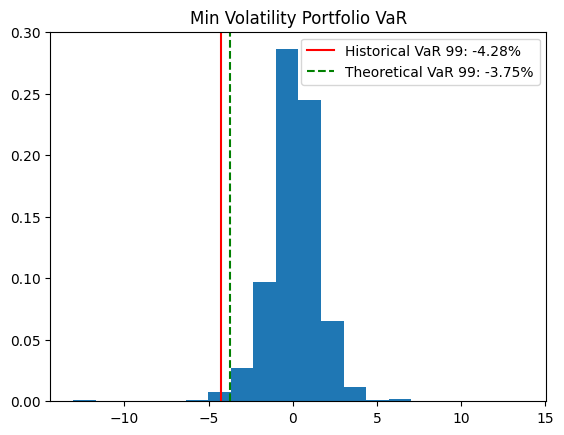

In [19]:
# For min volatility portfolio, make sure you run first question codes first 
mv_daily_return = daily_returns.dot(optimal_weights_minvol)
mv_StockReturns_perc = mv_daily_return*100

# Calculate historical VaR(99)
mv_Hvar_99 = np.percentile(mv_StockReturns_perc, 1)
print(f"1% historical VaR of min volatility portfolio is: {np.round(mv_Hvar_99,4)}%.")

# Sort the returns for plotting
mv_sorted_rets = sorted(mv_StockReturns_perc)

# Calculate Theoretical and parametric VaR(99)
mv_mean = np.mean(mv_StockReturns_perc)
mv_std = np.std(mv_StockReturns_perc)
mv_Tvar_99 = norm.ppf(alpha, mv_mean, mv_std)
print(f"1% parametric/ theoretical VaR for min volatility portfolio is: {round(mv_Tvar_99,4)}%")

# Plot the probability of each sorted return quantile
plt.hist(mv_sorted_rets, bins=20 , density=True, stacked=True)

# Denote the VaR 99 quantile
plt.axvline(x=mv_Hvar_99, color='r', linestyle='-', label="Historical VaR 99: {0:.2f}%".format(mv_Hvar_99))
plt.axvline(x=mv_Tvar_99, color='g', linestyle='--', label="Theoretical VaR 99: {0:.2f}%".format(mv_Tvar_99))
plt.title("Min Volatility Portfolio VaR")
plt.legend()
plt.show()

### 4. Is the portfolio return for the maximum Sharpe portfolio statistically different from that of the equally weighted portfolio?
### 5. (Optional Bonus) What other hypotheses would you like to test? How do you test them? What do you find?

#### We first assume that the returns are normally distributed, independent of each other and have the same variance between the 2 portfolios.

In [28]:
import numpy as np 
from scipy.stats import t
# H0: No difference between max sharpe portfolio's and equally wtd portfolio's mean returns. 
# H1: There is difference in mean returns of max sharpe portfolio and equally wtd portfolio returns.

# Calculate test statistic (A slower way)
test_stat = (ew_mean-ms_mean)/np.sqrt(((ew_std**2)/daily_returns["AAPL.O"].count())+(ms_std**2)/daily_returns["AAPL.O"].count())
print("T-statistic:", test_stat,", but there is a faster way to calculate...")

# Below is the faster way of performing hypothesis testing for 2 samples... 

T-statistic: -0.7522583473666403 , but there is a faster way to calculate...


In [29]:
# Refresh memory with daily returns; Rerun Q1 codes if any error is encountered
ew_daily_ret = daily_returns.dot(ew_weights)
maxsharpe_daily_ret = daily_returns.dot(optimal_weights_maxsharpe)

In [33]:
import numpy as np
from scipy import stats

# Perform two-sample t-test
# H0: No difference between max sharpe portfolio's and equally wtd portfolio returns. 
# H1: There is difference in max sharpe portfolio and equally wtd portfolio returns.
t_statistic, p_value = stats.ttest_ind(ew_daily_ret, maxsharpe_daily_ret)

# Output results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Significance level
alpha = 0.05

# Interpret results
if p_value < alpha:
    print(f"At significance level = {alpha*100}%, we reject null hypothesis; There is a significant difference between two portfolio returns.")
else:
    print(f"At significance level = {alpha*100}%, we fail to reject null hypothesis; There is no significant difference between two portfolio returns.")

T-statistic: -0.751959535697506
P-value: 0.4521457299498448
At significance level = 5.0%, we fail to reject null hypothesis; There is no significant difference between two portfolio returns.


In [34]:
# H0: No difference between variances of max sharpe portfolio's and equally wtd portfolio returns. 
# H1: There is difference in variances of max sharpe portfolio and equally wtd portfolio returns.

# Calculate the variances of equally weighted and max Sharpe portfolios
ew_variance = ew_std**2
ms_variance = ms_std**2

# Perform F-test with degree of freedom (df)
ms_df = len(maxsharpe_daily_ret) - 1  
ew_df = len(ew_daily_ret) - 1 

# Calculate p-value
if ew_variance < ms_variance:
    f_statistic =  ms_variance / ew_variance
    p_value = stats.f.sf(f_statistic, ms_df, ew_df)
    
else:
    f_statistic =  ew_variance / ms_variance
    p_value = stats.f.sf(f_statistic, ew_df, ms_df)

# Output results
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# Significance level
alpha_2 = 0.05

# Interpret results
if p_value < alpha_2:
    print(f"At significance level = {alpha_2*100}%, we reject the null hypothesis; There is a significant difference in variances.")
else:
    print(f"At significance level = {alpha_2*100}%, we fail to reject the null hypothesis; There is no significant difference in variances.")

F-statistic: 1.1922044994808907
P-value: 0.0009193710119889608
At significance level = 5.0%, we reject the null hypothesis; There is a significant difference in variances.
